Code to (re)produce results in the paper 
"Manipulating the Online Marketplace of Ideas" 
by Xiaodan Lou, Alessandro Flammini, and Filippo Menczer
https://arxiv.org/abs/1907.06130

Notes:
* Need Python 3.6 or later; eg: `module load python/3.6.6`
* Remember link direction is following, opposite of info spread!
* For large `n_humans`, it's much faster to run the simulations in parallel on a server or cluster, eg, one process for each combination of parameters (gamma, phi, mu...)


Parameters and default values:
```
n_humans = 1000 # 10k for paper
beta = 0.1 # bots/humans ratio; 0.1 for paper
p = 0.5 # for network clustering; 0.5 for paper
k_out = 3 # average no. friends within humans & bots; 3 for paper
alpha = 15 # depth of feed; 15 for paper
mu = 0.75 # average prob of new meme vs retweet; 0.75 for paper or draw from empirical distribution
phi = 1 # bot deception >= 1: meme fitness higher than quality
gamma = 0.1 # infiltration: probability that a human follows each bot
epsilon = 0.01 # threshold used to check for steady-state convergence
n_runs = 10 # or 20? number of simulations to average results
csvfile = 'results.csv' # to save results for plotting
```

In [1]:
import networkx as nx
import random
import numpy
import math
import statistics
import csv
import matplotlib.pyplot as plt
from operator import itemgetter
import sys
import fcntl
import time
import bot_model

%matplotlib inline
assert(nx.__version__ >= '2.4')

# Analyses using an empirical retweet network
## Data from Hoaxy: 
* https://doi.org/10.5281/zenodo.1402266 (`M5_centralities.csv` and `user_bot_score.calibrated.csv`) 
* https://doi.org/10.5281/zenodo.1154839 (`retweet.preelection.all.csv`) 

In [14]:
# read retweet network from data and assign bot flags to nodes
# if we have bot score for a node from 'M5_centralities.csv', use it
# else if we have the bot score from 'user_bot_score.calibrated.csv', use that
# else assume node is human

# NB: we cannot add an empty list as a node attribute, so the feed will be added when reading the file

bot_score_raw = {}
with open('M5_centralities.csv') as file:
  next(file) # skip header line
  reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
  for row in reader:
    bot_score_raw[row[0]] = row[2]

bot_score_cal = {}
with open('user_bot_score.calibrated.csv') as file:
  next(file) # skip header line
  reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
  for row in reader:
    bot_score_cal[row[0]] = row[1]

retweets = nx.DiGraph()
with open('retweet.preelection.all.csv') as file:
  reader = csv.reader(file)
  next(reader) # skip header line
  for row in reader:
    n1 = int(row[0])
    n2 = int(row[1])
    retweets.add_edge(n1, n2)
    if n1 in bot_score_raw:
      bot_score = bot_score_raw[n1]
    elif n1 in bot_score_cal:
      bot_score = bot_score_cal[n1]
    else:
      bot_score = 0 # assuming human by default
    if bot_score > 0.5:
      retweets.nodes[n1]['bot'] = True
    else:
      retweets.nodes[n1]['bot'] = False
    if n2 in bot_score_raw:
      bot_score = bot_score_raw[n2]
    elif n2 in bot_score_cal:
      bot_score = bot_score_cal[n2]
    else:
      bot_score = 0 # assuming human by default
    if bot_score > 0.5:
      retweets.nodes[n2]['bot'] = True
    else:
      retweets.nodes[n2]['bot'] = False

print('the retweet network has', retweets.number_of_nodes(), 'nodes')
# 346,573

the retweet network has 346573 nodes


In [15]:
# SAVE EMPIRICAL RETWEET NETWORK TO FILE for faster reading in subsequent experiments

retweet_network_file = 'retweet_network.gml'

nx.write_gml(retweets, retweet_network_file)

In [ ]:
# RUN SIMULATION TO CALCULATE AVG QUALITY

avg_quality = bot_model.simulation(False, network=retweets, verbose=True) # should pass params mu, phi
print('average quality for empirical network:', avg_quality)
# 0.3310

In [24]:
RT = bot_model.read_empirical_network('retweet_network.gml')
n_bots, n_humans, beta, gamma = bot_model.calculate_beta_gamma(RT)
print (n_bots, 'bots and', n_humans, 'humans, for a ratio of beta =', beta)
print ('humans on average follow a fraction gamma =', gamma, 'of the bots')

# 3351 bots and 343222 humans, for a ratio of beta = 0.009763360157565657
# humans on average follow a fraction gamma = 1.9402037768854127e-05 of the bots

3351 bots and 343222 humans, for a ratio of beta = 0.009763360157565657
humans on average follow a fraction gamma = 1.9402037768854127e-05 of the bots


In [30]:
# sample to change the ratio of bots to humans (beta)

# initial network from file: extract bots and humans
RT = bot_model.read_empirical_network('retweet_network.gml', add_feed=False)
n_bots, n_humans, beta, gamma = bot_model.calculate_beta_gamma(RT)
bots = set([n for n, attr in RT.nodes(data=True) if attr['bot']])
humans = set([n for n, attr in RT.nodes(data=True) if not attr['bot']])
print('bots =', n_bots, 'humans =', n_humans, 'beta =', beta, 'gamma =', gamma)
filename = 'RT_h_' + str(n_humans) + '_b_' + str(n_bots) + '.gml'
nx.write_gml(RT, filename)

# downsample bots to decrease beta
RT_SAMPLE = RT.copy() # NOTE: the feed attributes will point to and be shared with the original!
bots_remaining = n_bots
while bots_remaining > 100:
    bots_to_delete = random.sample(bots, int(bots_remaining/2))
    bots = bots.difference(bots_to_delete)
    RT_SAMPLE.remove_nodes_from(bots_to_delete) 
    bots_remaining, humans_remaining, beta, gamma = bot_model.calculate_beta_gamma(RT_SAMPLE)
    print('bots =', bots_remaining, 'humans =', humans_remaining, 'beta =', beta, 'gamma =', gamma)
    filename = 'RT_h_' + str(humans_remaining) + '_b_' + str(bots_remaining) + '.gml'
    nx.write_gml(RT_SAMPLE, filename)
    
# downsample humans to increase beta
RT_SAMPLE = RT.copy() # NOTE: the feed attributes will point to and be shared with the original!
humans_remaining = n_humans
while humans_remaining > 10000:
    humans_to_delete = random.sample(humans, int(humans_remaining/2))
    humans = humans.difference(humans_to_delete)
    RT_SAMPLE.remove_nodes_from(humans_to_delete) 
    bots_remaining, humans_remaining, beta, gamma = bot_model.calculate_beta_gamma(RT_SAMPLE)
    print('bots =', bots_remaining, 'humans =', humans_remaining, 'beta =', beta, 'gamma =', gamma)
    filename = 'RT_h_' + str(humans_remaining) + '_b_' + str(bots_remaining) + '.gml'
    nx.write_gml(RT_SAMPLE, filename)

bots = 3351 humans = 343222 beta = 0.009763360157565657 gamma = 1.9402037768854127e-05
bots = 1676 humans = 343222 beta = 0.004883136861856175 gamma = 1.827758619708929e-05
bots = 838 humans = 343222 beta = 0.0024415684309280873 gamma = 1.8336691954243126e-05
bots = 419 humans = 343222 beta = 0.0012207842154640437 gamma = 1.9080729132514e-05
bots = 210 humans = 343222 beta = 0.000611848890805368 gamma = 1.9548641431853992e-05
bots = 105 humans = 343222 beta = 0.000305924445402684 gamma = 2.6444081312358915e-05
bots = 53 humans = 343222 beta = 0.00015441900577468811 gamma = 1.698664036467743e-05
bots = 3351 humans = 171611 beta = 0.019526720315131314 gamma = 1.7314460234327036e-05
bots = 3351 humans = 85806 beta = 0.03905321306202363 gamma = 1.8644627986043056e-05
bots = 3351 humans = 42903 beta = 0.07810642612404727 gamma = 1.7173507367111415e-05
bots = 3351 humans = 21452 beta = 0.15620921126235315 gamma = 1.2561616607442054e-05
bots = 3351 humans = 10726 beta = 0.3124184225247063 gam

In [ ]:
# MAIN: RUN SIMULATION TO CALCULATE AVG QUALITY using input network
# see empirical_beta.job and empirical_beta.py to run these in parallel 

for netfile in ['RT_h_10726_b_3351.gml','RT_h_343222_b_210.gml','RT_h_42903_b_3351.gml',
                'RT_h_171611_b_3351.gml','RT_h_343222_b_3351.gml','RT_h_5363_b_3351.gml',
                'RT_h_21452_b_3351.gml','RT_h_343222_b_419.gml','RT_h_85806_b_3351.gml',
                'RT_h_343222_b_105.gml','RT_h_343222_b_53.gml','RT_h_343222_b_1676.gml',
                'RT_h_343222_b_838.gml']:
    sampled_net = bot_model.read_empirical_network(netfile)
    n_bots, n_humans, beta, gamma = bot_model.calculate_beta_gamma(sampled_net)
    avg_quality = bot_model.simulation(False, network=sampled_net) # should pass params mu, phi
    bot_model.save_csv([n_bots, n_humans, beta, gamma, avg_quality])

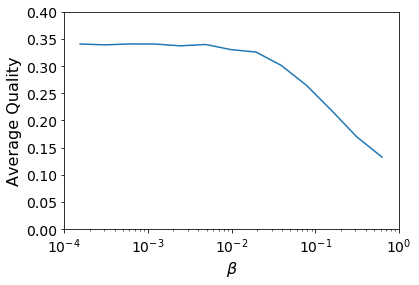

In [8]:
# PLOT AVG_Q vs BETA (after running simulations)

beta2q = {}
avg_q_values = []
with open('beta.csv', newline='') as file:
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        beta2q[row[2]] = row[4]

plt.xlabel(r'$\beta$', fontsize=16)
plt.ylabel('Average Quality', fontsize=16)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim((10**-4,1))
plt.ylim((0,0.4))
plt.plot(*zip(*sorted(beta2q.items())))

In [ ]:
# replace bots by an equal number (same BETA) of synthetic bots 
# with GAMMA as a parameter using empirical bot attachment for humans
# NB: THIS IS SLOW; BETTER RUN IN PARALLEL 

# initial network from file
RT = bot_model.read_empirical_network('retweet_network.gml', add_feed=False)

# for each human calculate vulnerability = number of bot friends
# (use later for probabilities of following synthetic bots)
# and also calculate the average out-degree of the bots
avg_bot_kout = 0
n_bots = 0
n_humans = 0
bots = []
for n in RT.nodes:
    bot_friends = 0
    for friend in RT.successors(n):
        if RT.nodes[friend]['bot']:
            bot_friends += 1
    if RT.nodes[n]['bot']:
        n_bots += 1
        avg_bot_kout += bot_friends
        bots.append(n)
    else:
        n_humans += 1
        RT.nodes[n]['vulnerability'] = bot_friends
avg_bot_kout /= n_bots
#print('avg_bot_kout =', avg_bot_kout) # avg_bot_kout = 3.245

#remove bots
RT.remove_nodes_from(bots)

# add synthetic bots; we preserve the empirical bot k_out, to the nearest integer 
# (happens to be 3 like in artificial networks :)
k_out = round(avg_bot_kout) 
B = bot_model.random_walk_network(n_bots)
for b in B.nodes:
    B.nodes[b]['bot'] = True

# create new networks with synthetic bots and have vulnerable humans follow bots according to GAMMA
for gamma in [0.00001, 0.0001, 0.001, 0.01, 0.1]: 
    SYN = nx.disjoint_union(RT, B)
    humans = []
    bots = []
    weights = []
    for n in SYN.nodes:
        if SYN.nodes[n]['bot']:
            bots.append(n)
        else:
            humans.append(n)
            weights.append(SYN.nodes[n]['vulnerability'])
            del SYN.nodes[n]['vulnerability'] # no longer needed
    n_followers = round(n_humans * gamma)
    for b in bots:
        followers = bot_model.sample_with_prob_without_replacement(humans, n_followers, weights)
        for f in followers:
            SYN.add_edge(f, b)
    filename = 'RT_gamma_' + str(gamma) + '.gml'
    nx.write_gml(SYN, filename)
    print('saved', filename)

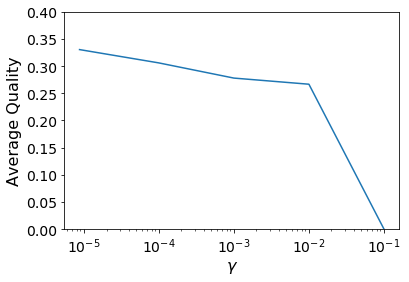

In [61]:
# PLOT AVG_Q vs GAMMA (after running simulations)

gamma2q = {}
avg_q_values = []
with open('gamma.csv', newline='') as file:
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        gamma2q[row[3]] = row[4]

plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel('Average Quality', fontsize=16)
plt.xscale('log')
plt.ylim((0,0.4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(*zip(*sorted(gamma2q.items())))

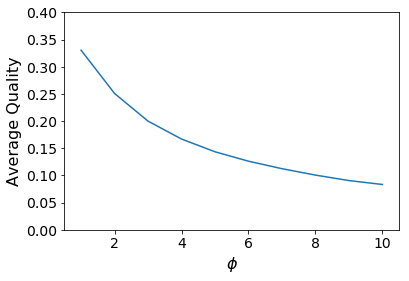

In [10]:
# PLOT AVG_Q vs PHI (after running experiments)

phi2q = {}
avg_q_values = []
with open('phi.csv', newline='') as file:
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        phi2q[row[0]] = row[1]

plt.xlabel(r'$\phi$', fontsize=16)
plt.ylabel('Average Quality', fontsize=16)
plt.xlim((0.5,10.5))
plt.ylim((0,0.4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(*zip(*sorted(phi2q.items())))

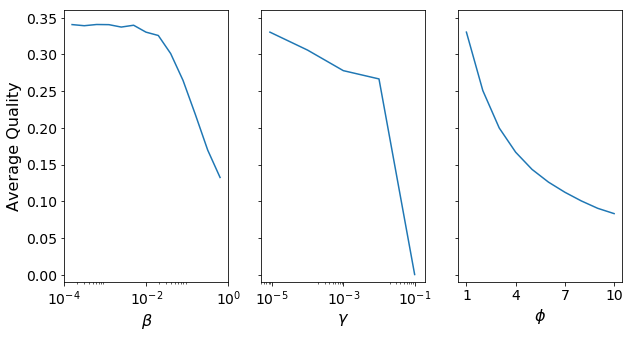

In [62]:
## Combine the three plots

fig, (ax_beta, ax_gamma, ax_phi) = plt.subplots(1,3, sharey=True, figsize=(10,5))
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim((-0.01,0.36))

ax_beta.set_xlabel(r'$\beta$', fontsize=16)
ax_beta.set_xscale('log')
ax_beta.set_xlim((10**-4,1))
ax_beta.plot(*zip(*sorted(beta2q.items())))
ax_beta.set_ylabel('Average Quality', fontsize=16)

ax_gamma.set_xlabel(r'$\gamma$', fontsize=16)
ax_gamma.set_xscale('log')
ax_gamma.set_xlim((5*10**-6,0.2))
ax_gamma.set_xticks([10**-5, 10**-3, 0.1])
ax_gamma.plot(*zip(*sorted(gamma2q.items())))

ax_phi.set_xlabel(r'$\phi$', fontsize=16)
ax_phi.set_xlim((0.5,10.5))
ax_phi.set_xticks([1,4,7,10])
ax_phi.plot(*zip(*sorted(phi2q.items())))

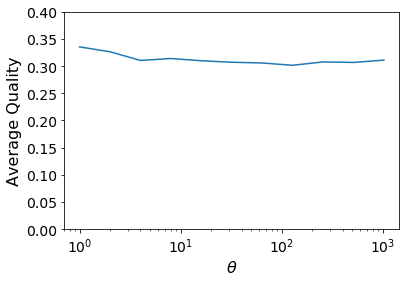

In [11]:
# PLOT AVG_Q vs FLOOD (after running experiments)
# FLOOD (theta) is a multiplier for content posted by bots 

flood2q = {}
avg_q_values = []
with open('flood.csv', newline='') as file:
    reader = csv.reader(file, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        flood2q[row[0]] = row[1]

plt.xlabel(r'$\theta$', fontsize=16)
plt.ylabel('Average Quality', fontsize=16)
plt.xscale('log')
plt.ylim((0,0.4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(*zip(*sorted(flood2q.items())))